Book Recommendation System using KNN

In [29]:
cd '/content/drive/My Drive/Colab Notebooks/Machine Learning/Book_recommendation_system'

/content/drive/My Drive/Colab Notebooks/Machine Learning/Book_recommendation_system


In [30]:
!pwd

/content/drive/My Drive/Colab Notebooks/Machine Learning/Book_recommendation_system


In [31]:
ls

'Book Recommendation System using KNN.ipynb'   ratings.csv       to_read.csv
 books.csv                                     sample_book.xml
 book_tags.csv                                 tags.csv


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
rating = pd.read_csv('ratings.csv')
books = pd.read_csv('books.csv', usecols = ['book_id', 'original_title']) #cols = ['book_id', 'original_title']
tags = pd.read_csv('tags.csv')
to_read = pd.read_csv('to_read.csv')


In [33]:
rating.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [34]:
books.head()

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
2,41865,Twilight
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby


In [35]:
books.book_id.unique #10000


<bound method Series.unique of 0       2767052
1             3
2         41865
3          2657
4          4671
         ...   
9995    7130616
9996     208324
9997      77431
9998    8565083
9999       8914
Name: book_id, Length: 10000, dtype: int64>

In [36]:
books.isna().count()

book_id           10000
original_title    10000
dtype: int64

In [37]:
tags.head()


,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [38]:
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [39]:
#Merging these two df to get title and userid in the same frame
df = pd.merge(rating,books,on='book_id')
df.head()

,book_id,user_id,rating,original_title
0,1,314,5,Harry Potter and the Half-Blood Prince
1,1,439,3,Harry Potter and the Half-Blood Prince
2,1,588,5,Harry Potter and the Half-Blood Prince
3,1,1169,4,Harry Potter and the Half-Blood Prince
4,1,1185,4,Harry Potter and the Half-Blood Prince


In [40]:
#Calculating total no of ratings given to each book
k = df.groupby(['book_id'])['user_id'].count()
k


book_id
1       100
2       100
3       100
5       100
6       100
       ... 
9914     94
9915     90
9943     89
9957     92
9998     95
Name: user_id, Length: 812, dtype: int64

In [41]:
#Creating a new dataframe which will contain bookid and total no of ratings given for each book.
dic = {'book_id': k.index.values , 'ratings_count': k.values}
df2 = pd.DataFrame(dic)
df2.head()

,book_id,ratings_count
0,1,100
1,2,100
2,3,100
3,5,100
4,6,100


In [42]:
#Exploring df2
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df2['ratings_count'].describe())

count   812.000
mean     98.154
std       5.546
min      57.000
25%      99.000
50%     100.000
75%     100.000
max     100.000
Name: ratings_count, dtype: float64


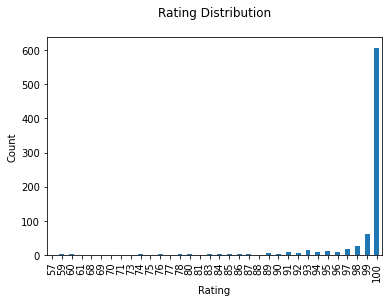

In [43]:
#Exploring df2
plt.rc("font", size=10)
df2.ratings_count.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [44]:
# Merging df2 in df
rating_with_totalRatingCount = df.merge(df2, left_on = 'book_id', right_on = 'book_id', how = 'left')
rating_with_totalRatingCount.head()

,book_id,user_id,rating,original_title,ratings_count
0,1,314,5,Harry Potter and the Half-Blood Prince,100
1,1,439,3,Harry Potter and the Half-Blood Prince,100
2,1,588,5,Harry Potter and the Half-Blood Prince,100
3,1,1169,4,Harry Potter and the Half-Blood Prince,100
4,1,1185,4,Harry Potter and the Half-Blood Prince,100


In [45]:
# Removing those books which have given less no of ratings than popularity threshold
popularity_threshold = 75
rating_popular_book = rating_with_totalRatingCount.query('ratings_count >= @popularity_threshold')
rating_popular_book.head()


,book_id,user_id,rating,original_title,ratings_count
0,1,314,5,Harry Potter and the Half-Blood Prince,100
1,1,439,3,Harry Potter and the Half-Blood Prince,100
2,1,588,5,Harry Potter and the Half-Blood Prince,100
3,1,1169,4,Harry Potter and the Half-Blood Prince,100
4,1,1185,4,Harry Potter and the Half-Blood Prince,100


In [46]:
rating_popular_book.shape

(78846, 5)

In [47]:
#Creating pivot matrix
book_features_df=rating_popular_book.pivot_table(index='original_title',columns='user_id',values='rating').fillna(0)
book_features_df.head()

user_id,3,4,7,9,10,11,14,15,20,22,23,24,27,29,31,35,36,40,41,46,47,49,51,52,55,57,60,61,62,69,75,82,83,87,89,90,93,95,96,101,...,53341,53342,53344,53345,53348,53349,53350,53352,53354,53355,53356,53357,53364,53366,53371,53372,53373,53374,53377,53378,53381,53382,53388,53389,53390,53391,53393,53398,53400,53401,53403,53406,53408,53409,53416,53419,53420,53422,53423,53424
original_title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Animal Farm & 1984,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
Carter Beats the Devil,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
The Fellowship of the Ring,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
"めくらやなぎと、眠る女 [Mekurayanagi to, nemuru onna]",0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [48]:
book_features_df.shape

(781, 28026)

In [49]:
from scipy.sparse import csr_matrix

book_features_df_matrix = csr_matrix(book_features_df.values)

from sklearn.neighbors import NearestNeighbors


model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(book_features_df_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [50]:
#Chosing a random book from dataset as a input to the system to calculate other recommendions for that book
query_index = np.random.choice(book_features_df.shape[0])
print(query_index)
distances, indices = model_knn.kneighbors(book_features_df.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

607


In [51]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(book_features_df.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, book_features_df.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for The No. 1 Ladies' Detective Agency :

1: Microserfs, with distance of 0.8195290924370764:
2: The Short Stories of F. Scott Fitzgerald, with distance of 0.8363284531703363:
3: Enchantment, with distance of 0.861327874775579:
4: Skinny Legs and All, with distance of 0.8807619112078093:
5: The Beach House, with distance of 0.883625440643703:
